In [1]:
import numpy as np
from astroquery.svo_fps import SvoFps
from astropy.stats import biweight_location


def m_UV(data,lamb_emit=1500):
    """
    Parameters: 
    data      = Dataset with redshifts and magnitudes of galaxies in HST ACS/WFC and JWST/NIRCam
    Used column names: filtername_MAG for magnitudes ; filtername_MAGERR for corresponding errors and ZSYS for redshifts 
    
    lamb_emit = Target restframe wavelength [Angstrom] 
    
    Returns an array of apparent magnitudes 
    """

    # Determining the observed wavelength from redshift
    redshifts = np.array(data['ZSYS'])
    lamb_obs = lamb_emit*(1+redshifts)  

    # Getting filter names from the dataset
    filters = np.array([cell for cell in data.keys() if cell.endswith('_MAG')])
    filters = [f.replace('_MAG', '') for f in filters]

    # Getting data for filters in those instruments
    NIRCam = SvoFps.get_filter_list(facility='JWST', instrument='NIRCam')
    WFC = SvoFps.get_filter_list(facility='HST', instrument='WFC3')
    ACS = SvoFps.get_filter_list(facility='HST', instrument='ACS')

    # Sorting filters by instrument
    fromWFC = filters[:3]+filters[9:11]+filters[12:14]+[filters[15]]
    fromACS = filters[3:8]
    fromNIRCam = [filters[8]]+[filters[11]]+[filters[14]]+filters[16:]

    # Could also do the sorting automatically like below:
    
    # NIRCam_names = [filter['filterID'].split('.')[-1] for filter in NIRCam]
    # fromNIRCam = [filter for filter in filters if filter in NIRCam_names]
    
    # but some filters overlap between instruments so I opted to do the sorting by hand for consistency    


    # Get min and max wavelengths covered by each filter. Sometimes there are 
    # several similar filters for each instrument, hence the try-except blocks. Oh well
    
    boundaries=[]   
    for filter in filters:
        if filter in fromWFC:
            try:
                idx = np.where([filter in WFC[i][1] for i in range(len(WFC))])[0][0] 
            except:
                idx = np.where([filter in WFC[i][1] for i in range(len(WFC))])[0]
            boundaries.append([WFC[idx]['WavelengthMin'],WFC[idx]['WavelengthMax']])

        elif filter in fromACS:
            try:
                idx = np.where([filter in ACS[i][1] for i in range(len(ACS))])[0][0]
            except:
                idx = np.where([filter in ACS[i][1] for i in range(len(ACS))])[0] 
            boundaries.append([ACS[idx]['WavelengthMin'],ACS[idx]['WavelengthMax']])
            
        elif filter in fromNIRCam:
            try:
                idx = np.where([filter in NIRCam[i][1] for i in range(len(NIRCam))])[0][0]
            except:
                idx = np.where([filter in NIRCam[i][1] for i in range(len(NIRCam))])[0]
            boundaries.append([NIRCam[idx]['WavelengthMin'],NIRCam[idx]['WavelengthMax']])

    
    # Determine the matching filters that cover the required wavelength for each object
    matches = [0]*len(redshifts) 
    for i in range(len(redshifts)):             # for each object
        
        match = []                          
        lamb = lamb_obs[i]                      # object's target restframe wavelength
        closest_filter = None                   # closest filter in case no match is found   
        smallest_diff = np.inf                  # difference between lamb and filters to determine closest one
        
        for j in range(len(filters)):           # for each filter
            min_wave, max_wave = boundaries[j]  
            diff = min(abs(lamb - min_wave), abs(lamb - max_wave))
            if min_wave <= lamb <= max_wave and data[filters[j]+'_MAGERR'][i]!=-1.:
                match.append(filters[j])        # Filter is a match if it covers the wavelength and is not an upper limit (with error -1)
            elif diff < smallest_diff:          
                smallest_diff = diff
                closest_filter = filters[j]
            
        if len(match)==0:                        # If still no matches, append one closest filter
            match.append(closest_filter)
        matches[i] = match
            
    # Final apparent magnitudes
    mags = [] 
    
    for i in range(len(matches)):
        magobj = np.nanmean([data[filt+'_MAG'][i] for filt in matches[i]]) # Mean magnitude in matching filters for each object
        mags.append(magobj)
        
    return np.array(mags)



def best_m_UV(data,lamb_range=np.arange(1500, 2501,10)):
    """
    Calls the m_UV function for a range of wavelengths [A]
    Output: apparent magnitude's biweight_location across all wavelenghs considered for each object
    """
    
    allmags = [m_UV(data,lamb_emit=lamb) for lamb in lamb_range]
    return biweight_location(np.array(allmags), axis=0)



def k(lamb=.15, R=4.05):
    """
    Starburst reddening curve from Calzetti,2000 (eq.4 and 5 combined)
    """
    return 2.659*(-2.156+1.509/lamb-0.198/(lamb**2)+0.011/(lamb**3))+R



def SFR(data, galaxies, C_UV=8.82e-29):
    """
    Input: 
    data     = Data with apparent magnitudes and redshfts for the objects
    galaxies = list of galaxy objects, parameters used are E(B-V) as self.bv and Luminosity distance as self.lumdist

    C_UV = 8.82e−29 [Msun yr−1 erg−1 s Hz]

    Output: SFR [log Msun/yr]
    """
    
    ms = best_m_UV(data)                                                   # Apparent magnitudes
    bv = np.array([gal.bv for gal in galaxies])                            # E(B-V) 
    lumdist = np.array([gal.lumdist for gal in galaxies])                  # Luminocity distance [pc]
    redshifts = np.array(data['ZSYS'])                                     # Redhift
    Ms = ms - 5*np.log10(lumdist/10) + 2.5*np.log10(redshifts+1) - k()*bv  # Distance modulus with redshift and dust correction 
    monoch_lum = 10**(-.4*(-51.6 + Ms))                                    # Monochromatic luminosity (Iani+24 eq.3 or Kennicutt & Evans 2012)
    sfr = np.log10(C_UV*monoch_lum)                                           
    
    return sfr

# Example usage

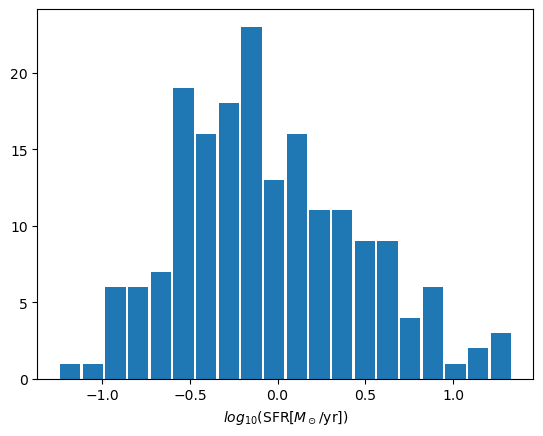

In [2]:
import csv
from astropy.io import fits
import os
import matplotlib.pyplot as plt


def getdata(path):
    """
    Retrieves SED mags from a csv file
    """
    with open(path, 'r') as csvfile:
        read = csv.reader(csvfile)
        header = next(read)  
        dict = {key: [] for key in header}
        for row in read:
            for idx, value in enumerate(row):
                if value:                             # If not empty
                    dict[header[idx]].append(float(value))
                else:
                    dict[header[idx]].append(np.nan)  # If empty
    return dict
    

class Galaxy:
    def __init__(self,bv,lumdist,magspath='LAEs_XDF_Iani+24.csv'):
            
        self.bv = float(bv)
        self.lumdist = float(lumdist)/(3.08e16) # m to pc


def get(folder):
    
    """
    Gets best fit CIGALE outputs from the output folder
    """
    
    gals = []    
    with fits.open(os.path.join(folder, 'results.fits')) as hdul:
        data = hdul[1].data
        for i in range(len(data)):
            gals.append(Galaxy(data[i]['bayes.attenuation.E_BVs'], data[i]['best.universe.luminosity_distance']))
    hdul.close()
    return gals



SED_mags = getdata('LAEs_XDF_Iani+24.csv')
Galaxies = get('oburst')

plt.hist(SFR(SED_mags, Galaxies), rwidth=.9, bins=20)
plt.xlabel(r'$log_{10}$(SFR[$M_\odot$/yr])')
plt.show()